# Field operations 2

In this notebook, we show (and compare) computing individual energy terms:

In [1]:
import discretisedfield as df
import micromagneticmodel as mm
import oommfc as mc

As an example, we use skyrmion magnetisation field.

Running OOMMF (ExeOOMMFRunner)[2023/09/01 09:09]... (0.3 s)


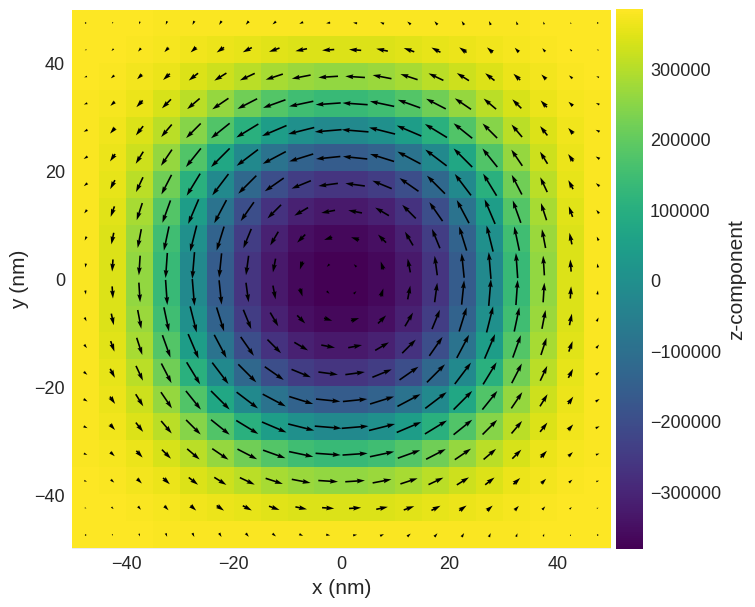

In [2]:
# Geometry
L = 100e-9
thickness = 5e-9
cell = (5e-9, 5e-9, 5e-9)
p1 = (-L/2, -L/2, 0)
p2 = (L/2, L/2, thickness)
region = df.Region(p1=p1, p2=p2)
mesh = df.Mesh(region=region, cell=cell, bc="xy")

# Parameters
Ms = 3.84e5
A = 8.78e-12
D = 1.58e-3
K = 1e4
u = (0, 0, 1)
H = (0, 0, 1e5)
system = mm.System(name='skyrmion')
system.energy = mm.Exchange(A=A) + mm.DMI(D=D, crystalclass='T') + mm.Zeeman(H=H) + mm.UniaxialAnisotropy(K=K, u=u)

def m_initial(point):
    x, y, z = point
    if x**2 + y**2 < (L/4)**2:
        return (0, 0, -1)
    else:
        return (0, 0, 1)
    
system.m = df.Field(mesh, nvdim=3, value=m_initial, norm=Ms)

md = mc.MinDriver()
md.drive(system)

system.m.sel('z').mpl(figsize=(9, 7))

## Magnetisation

$$\mathbf{m} = \frac{\mathbf{M}}{M_\text{s}}$$

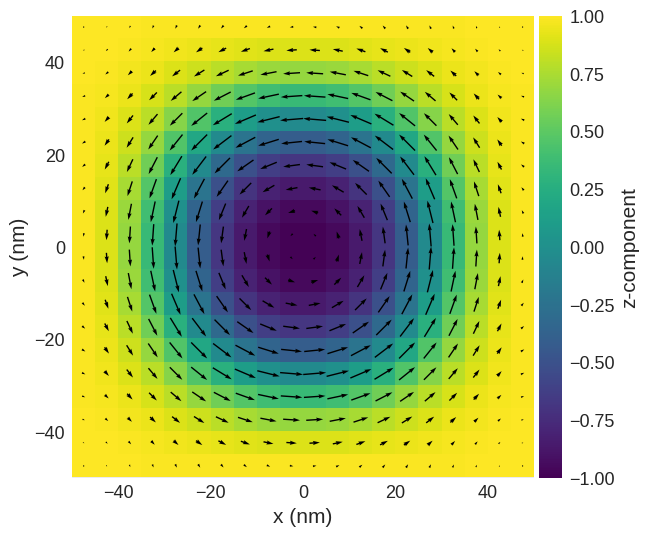

In [3]:
m = system.m.orientation

m.sel('z').mpl(scalar_kw={'clim': (-1, 1)})

## Zeeman

| property | equation in continuous form | discretisedfield form |
|-|-|-|
| Energy density | $w = -\mu_{0}M_\text{s}\mathbf{m}\cdot\mathbf{H}$ | `- mu0 * Ms * m.dot(H)` |
| Energy | $E = -\int_{V}\mu_{0}M_\text{s}\mathbf{m}\cdot\mathbf{H} dV$ | `(- mu0 * Ms * m.dot(H)).integrate()` |
| Effective field | $\mathbf{H}_\text{eff} = \mathbf{H}$ | `H` |

#### Energy density

In [4]:
wdf = - mm.consts.mu0 * Ms * m.dot(H)
wmc = mc.compute(system.energy.zeeman.density, system)
wdf.allclose(wmc)

Running OOMMF (ExeOOMMFRunner)[2023/09/01 09:09]... (0.2 s)


True

#### Energy

In [5]:
Edf = (- mm.consts.mu0 * Ms * m.dot(H)).integrate()
Emc = mc.compute(system.energy.zeeman.energy, system)
print(f'df: {Edf}')
print(f'mc: {Emc}')
print(f'rerr: {abs(Edf-Emc)/Edf * 100} %')

Running OOMMF (ExeOOMMFRunner)[2023/09/01 09:09]... (0.2 s)
df: [-1.03472186e-18]
mc: -1.03472185973e-18
rerr: [-3.38068296e-10] %


#### Effective field

In [6]:
Hdf = df.Field(mesh, nvdim=3, value=H)
Hmc = mc.compute(system.energy.zeeman.effective_field, system)
Hdf.allclose(Hmc)

Running OOMMF (ExeOOMMFRunner)[2023/09/01 09:09]... (0.2 s)


True

## Uniaxial anisotropy

| property | equation in continuous form | discretisedfield form |
|-|-|-|
| Energy density | $w = K |\mathbf{m} \times \mathbf{u}|^{2}$ | `K * abs(m.cross(u)).dot(abs(m.cross(u)))` |
| Energy | $E = \int_{V}K |\mathbf{m} \times \mathbf{u}|^{2} dV$ | `(K * abs(m.cross(u)).dot(abs(m.cross(u)))).integrate()` |
| Effective field | $\mathbf{H}_\text{eff} = \frac{2K}{\mu_{0}M_\text{s}} (\mathbf{m} \cdot \mathbf{u})\mathbf{u}$ | `2 * K / (mm.consts.mu0 * Ms) * (m.dot(u)) * u` |

#### Energy density

In [7]:
wdf = K * abs(m.cross(u)).dot(abs(m.cross(u)))
wmc = mc.compute(system.energy.uniaxialanisotropy.density, system)
wdf.allclose(wmc)

Running OOMMF (ExeOOMMFRunner)[2023/09/01 09:09]... (0.2 s)


True

#### Energy

In [8]:
Edf = (K * abs(m.cross(u)).dot(abs(m.cross(u)))).integrate()
Emc = mc.compute(system.energy.uniaxialanisotropy.energy, system)
print(f'df: {Edf}')
print(f'mc: {Emc}')
print(f'rerr: {abs(Edf-Emc)/Edf * 100} %')

Running OOMMF (ExeOOMMFRunner)[2023/09/01 09:09]... (0.2 s)
df: [2.0433559e-19]
mc: 2.04335590123e-19
rerr: [4.92591201e-11] %


#### Effective field

In [9]:
Hdf = 2 * K / (mm.consts.mu0 * Ms) * (m.dot(u)) * u
Hmc = mc.compute(system.energy.uniaxialanisotropy.effective_field, system)
Hdf.allclose(Hmc)

Running OOMMF (ExeOOMMFRunner)[2023/09/01 09:09]... (0.2 s)


True

## Exchange

| property | equation in continuous form | discretisedfield form |
|-|-|-|
| Energy density | $w = - A \mathbf{m} \cdot \nabla^{2} \mathbf{m}$ | `- A * m.dot(m.laplace)` |
| Energy | $E = -\int_{V} A \mathbf{m} \cdot \nabla^{2} \mathbf{m} dV$ | `(- A * m.dot(m.laplace)).integrate()` |
| Effective field | $\mathbf{H}_\text{eff} = \frac{2A}{\mu_{0}M_\text{s}} \nabla^{2} \mathbf{m}$ | `2 * A / (mu0 * Ms) * m.laplace` |

#### Energy density

In [10]:
wdf = - A * m.dot(m.laplace)
wmc = mc.compute(system.energy.exchange.density, system)
wdf.allclose(wmc)

Running OOMMF (ExeOOMMFRunner)[2023/09/01 09:09]... (0.2 s)


True

#### Energy

In [11]:
Edf = (- A * m.dot(m.laplace)).integrate()
Emc = mc.compute(system.energy.exchange.energy, system)
print(f'df: {Edf}')
print(f'mc: {Emc}')
print(f'rerr: {abs(Edf-Emc)/Edf * 100} %')

Running OOMMF (ExeOOMMFRunner)[2023/09/01 09:09]... (0.2 s)
df: [1.74383742e-18]
mc: 1.74383742382e-18
rerr: [1.52432129e-10] %


#### Effective field

In [12]:
Hdf = 2 * A / (mm.consts.mu0 * Ms) * m.laplace
Hmc = mc.compute(system.energy.exchange.effective_field, system)
Hdf.allclose(Hmc)

Running OOMMF (ExeOOMMFRunner)[2023/09/01 09:09]... (0.2 s)


True

## DMI (T)

| property | equation in continuous form | discretisedfield form |
|-|-|-|
| Energy density | $w = D \mathbf{m} \cdot (\nabla \times \mathbf{m})$ | `D * m @ m.curl` |
| Energy | $E = \int_{V} D \mathbf{m} \cdot (\nabla \times \mathbf{m}) dV$ | `(D * m @ m.curl).volume_integral` |
| Effective field | $\mathbf{H}_\text{eff} = -\frac{2D}{\mu_{0}M_\text{s}} (\nabla \times \mathbf{m})$ | `- 2 * D / (mu0 * Ms) * m.curl` |

#### Energy density

In [13]:
wdf = D * m.dot(m.curl)
wmc = mc.compute(system.energy.dmi.density, system)
wdf.allclose(wmc)

Running OOMMF (ExeOOMMFRunner)[2023/09/01 09:09]... (0.2 s)


True

#### Energy

In [14]:
Edf =(D * m.dot(m.curl)).integrate()
Emc = mc.compute(system.energy.dmi.energy, system)
print(f'df: {Edf}')
print(f'mc: {Emc}')
print(f'rerr: {abs(Edf-Emc)/Edf * 100} %')

Running OOMMF (ExeOOMMFRunner)[2023/09/01 09:09]... (0.2 s)
df: [-4.35058832e-18]
mc: -4.35058832402e-18
rerr: [-6.46139588e-11] %


#### Effective field

In [15]:
Hdf = - 2 * D / (mm.consts.mu0 * Ms) * m.curl
Hmc = mc.compute(system.energy.dmi.effective_field, system)
Hdf.allclose(Hmc)

Running OOMMF (ExeOOMMFRunner)[2023/09/01 09:09]... (0.2 s)


True

## (Oversimplified) micromagnetic calculator

Here we try to implement an (oversimplified) micromagnetic calculator we had a look at in the first session:

<img src="figures/algorithm.png" width="600">

We start by defining some basic parameters:

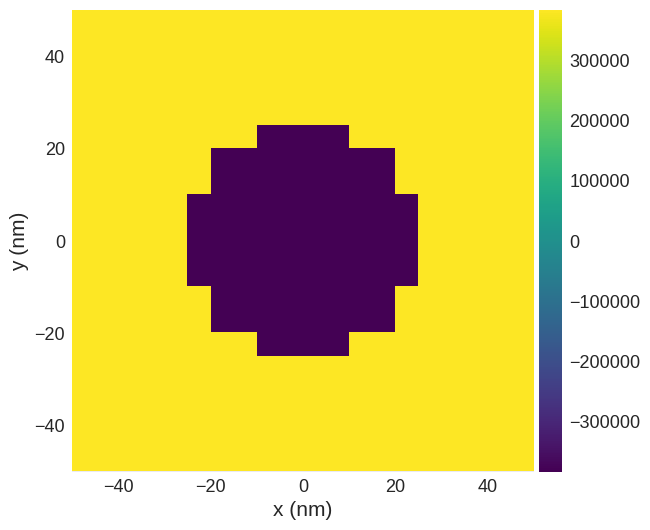

In [16]:
# Geometry
L = 100e-9
thickness = 5e-9
cell = (5e-9, 5e-9, 5e-9)
p1 = (-L/2, -L/2, 0)
p2 = (L/2, L/2, thickness)
region = df.Region(p1=p1, p2=p2)
mesh = df.Mesh(region=region, cell=cell, bc='xy')

# Material parameters
Ms = 3.84e5
A = 8.78e-12
D = 1.58e-3
K = 1e4
u = (0, 0, 1)
H = (0, 0, 1e5)
alpha = 1

def m_initial(point):
    x, y, z = point
    if x**2 + y**2 < (L/4)**2:
        return (0, 0, -1)
    else:
        return (0, 0, 1)
    
# Magnetisation field (M=Ms*m)
M = df.Field(mesh, nvdim=3, value=m_initial, norm=Ms)

M.sel('z').z.mpl()

Up to this point, everything should be exactly the same as we saw previously.

In the next step, we are going to implement functions which we are going to use to compute effective field and magnetisation time-derivative. The effective field we want is:

$$\mathbf{H}_\text{eff} = f(\mathbf{m}) = \frac{2A}{\mu_{0}M_\text{s}} \nabla^{2} \mathbf{m} - \frac{2D}{\mu_{0}M_\text{s}} (\nabla \times \mathbf{m}) + \frac{2K}{\mu_{0}M_\text{s}} (\mathbf{m} \cdot \mathbf{u})\mathbf{u} + \mathbf{H}$$

Dynamics equation we are going to use consists only of Damping term (in order to make simulations faster):

$$\frac{d\mathbf{m}}{dt} = f(\mathbf{m}, \mathbf{H}_\text{eff}) = -\frac{\gamma_{0}\alpha}{1+\alpha^{2}} \mathbf{m} \times (\mathbf{m} \times \mathbf{H}_\text{eff})$$

In [17]:
def Heff_function(m):
    return (2 * A / (mm.consts.mu0 * Ms) * m.laplace -
            2 * D / (mm.consts.mu0 * Ms) * m.curl +
            2 * K / (mm.consts.mu0 * Ms) * (m.dot(u)) * u +
            df.Field(mesh, nvdim=3, value=H))
    
def dmdt_function(m, Heff):
    return -(mm.consts.gamma0*alpha)/(1+alpha**2) * m.cross(m.cross(Heff)) 

Now, we can try to perform the time integration, so that at each step we update our magnetisation:

$$\mathbf{m}_{i+1} = \mathbf{m}_{i} + \frac{d\mathbf{m}_{i}}{dt} \Delta t$$

So, our ubermag time driver would be:

In [18]:
T = 0.1e-9  # simulation time (s)
n = 100  # number of steps
dt = T/n

for i in range(n):
    m = M.orientation
    m += dmdt_function(m, Heff_function(m)) * dt
    M = df.Field(mesh, nvdim=3, value=m, norm=Ms)

Finally, we can plot the magnetisation:

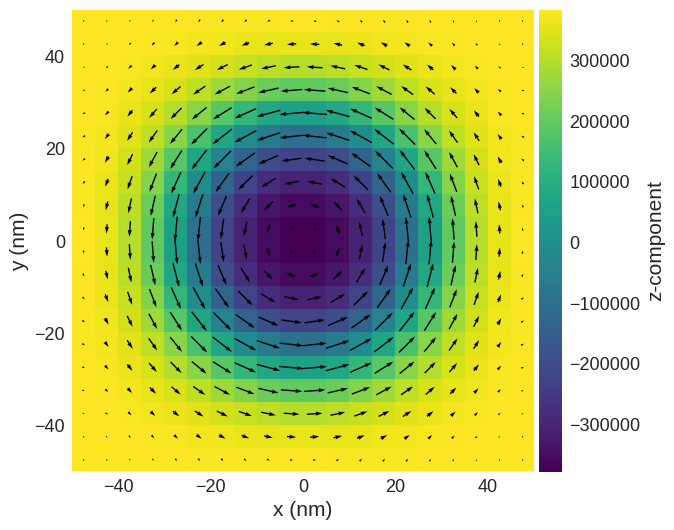

In [19]:
M.sel('z').mpl()